# Scanpy

https://github.com/mousepixels/sanbomics_scripts/blob/main/single_cell_analysis_complete_class.ipynb

In [10]:
import pandas as pd
from fonctions import * #fonction ``patients``

bt = pd.read_csv('processed_data/bt_traitement1.csv', sep=',', low_memory=False)
bt.set_index('Unnamed: 0', inplace=True)
bt.head()

,AAACCCAGTCTCAGAT.1_1,AAACCCAGTGTCCGGT.1_1,AAACCCATCGGCTATA.1_1,AAACGAAAGAGCCCAA.1_1,AAACGAATCTTACGTT.1_1,AAACGCTAGGCCCAAA.1_1,AAAGAACCACTGGACC.1_1,AAAGAACGTAGAAACT.1_1,AAAGGATAGCACCGTC.1_1,AAAGGATAGGCCTGCT.1_1,...,TTTACTGAGAATAGGG.1_43,TTTACTGCACTTACGA.1_43,TTTATGCTCACGATGT.1_43,TTTATGCTCCAAATGC.1_43,TTTGCGCAGTCTCGGC.1_43,TTTGCGCTCACAAACC.1_43,TTTGGTTAGAACTGTA.1_43,TTTGGTTGTTGCGCAC.1_43,TTTGGTTTCGGCGGTT.1_43,TTTGTCACATGCCTAA.1_43
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Bt_Ot_matrix,BT,BT,BT,BT,BT,BT,BT,BT,BT,BT,...,BT,BT,BT,BT,BT,BT,BT,BT,BT,BT
patient_matrix,14,14,14,14,14,14,14,14,14,14,...,38,38,38,38,38,38,38,38,38,38
sample_matrix,scrCMA036,scrCMA036,scrCMA036,scrCMA036,scrCMA036,scrCMA036,scrCMA036,scrCMA036,scrCMA036,scrCMA036,...,sc5rCMA144,sc5rCMA144,sc5rCMA144,sc5rCMA144,sc5rCMA144,sc5rCMA144,sc5rCMA144,sc5rCMA144,sc5rCMA144,sc5rCMA144
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [ ]:
liste_patients = bt.loc['patient_matrix'].unique().tolist()
liste_patients

In [ ]:
for i in liste_patients:
    p = patients(i, bt)
    p.to_csv(f'patients_matrix/patient_{i}.csv', sep=',', index=True)

In [11]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [12]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

In [13]:
import scanpy as sc
import scvi

# Intégration des patients

In [14]:
def pp(csv_path):

    #doublons
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)] 
    doublets.index = [i.split('.')[0] for i in doublets.index]
    
    adata = sc.read_csv(csv_path).T
    adata.obs.index = [ i.split('.')[0] for i in adata.obs.index ]
    adata.obs['Sample'] = csv_path.split('/')[-1].split('.')[0] #'patients_matrix/patient_14.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    #preprocessing
    sc.pp.filter_cells(adata, min_genes=200) 
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]

    #Filtrage des "outliers" 
    #adata = adata[adata.obs.pct_counts_mt < 20]
    #adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [15]:
import os

os.listdir('patients_matrix')

['patient_25.csv',
 'patient_26.csv',
 'patient_36.csv',
 'patient_22.csv',
 'patient_23.csv',
 'patient_37.csv',
 'patient_21.csv',
 'patient_38.csv',
 'patient_17.csv',
 'patient_16.csv',
 'patient_14.csv',
 'patient_29.csv',
 'patient_15.csv']

In [16]:
out = []
for file in os.listdir('patients_matrix'):
    out.append(pp('patients_matrix/' + file))

/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 400/400: 100%|██████████| 400/400 [00:43<00:00,  8.97it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.38e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:43<00:00,  9.25it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.38e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 295/400:  74%|███████▍  | 295/400 [00:05<00:02, 51.67it/s, v_num=1, train_loss_step=0.478, train_loss_epoch=0.456]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.448. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [00:26<00:00, 15.09it/s, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.96e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:26<00:00, 15.30it/s, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.96e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 196/400:  49%|████▉     | 196/400 [00:02<00:02, 68.92it/s, v_num=1, train_loss_step=0.116, train_loss_epoch=0.322] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.365. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [00:31<00:00, 13.05it/s, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.62e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:31<00:00, 12.53it/s, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.62e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 211/400:  53%|█████▎    | 211/400 [00:03<00:03, 59.13it/s, v_num=1, train_loss_step=0.327, train_loss_epoch=0.358]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.311. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [00:15<00:00, 25.29it/s, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=1.92e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:15<00:00, 25.15it/s, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=1.92e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 31/400:   8%|▊         | 31/400 [00:00<00:03, 101.91it/s, v_num=1, train_loss_step=0.508, train_loss_epoch=0.477]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.699. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [00:32<00:00, 12.96it/s, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.13e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:32<00:00, 12.26it/s, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.13e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 31/400:   8%|▊         | 31/400 [00:00<00:06, 54.83it/s, v_num=1, train_loss_step=0.325, train_loss_epoch=0.341]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.904. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [01:21<00:00,  5.47it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.38e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:21<00:00,  4.92it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.38e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 194/400:  48%|████▊     | 194/400 [00:06<00:07, 27.99it/s, v_num=1, train_loss_step=0.424, train_loss_epoch=0.365]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.407. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [00:15<00:00, 24.02it/s, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.83e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:15<00:00, 26.08it/s, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.83e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 31/400:   8%|▊         | 31/400 [00:00<00:03, 93.94it/s, v_num=1, train_loss_step=0.369, train_loss_epoch=0.431] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.947. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [00:46<00:00,  8.41it/s, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.66e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:46<00:00,  8.67it/s, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.66e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 131/400:  33%|███▎      | 131/400 [00:02<00:05, 47.39it/s, v_num=1, train_loss_step=0.322, train_loss_epoch=0.347]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.424. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [00:40<00:00, 10.44it/s, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:40<00:00,  9.99it/s, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 170/400:  42%|████▎     | 170/400 [00:03<00:05, 44.80it/s, v_num=1, train_loss_step=0.181, train_loss_epoch=0.279] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.332. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [01:11<00:00,  5.70it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.15e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:11<00:00,  5.60it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.15e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 93/400:  23%|██▎       | 93/400 [00:02<00:09, 33.06it/s, v_num=1, train_loss_step=0.318, train_loss_epoch=0.391]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.503. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [02:12<00:00,  2.32it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.02e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:12<00:00,  3.01it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.02e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 241/400:  60%|██████    | 241/400 [00:18<00:12, 12.92it/s, v_num=1, train_loss_step=0.341, train_loss_epoch=0.301]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.332. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [00:14<00:00, 28.26it/s, v_num=1, train_loss_step=2.46e+3, train_loss_epoch=2.45e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:14<00:00, 28.40it/s, v_num=1, train_loss_step=2.46e+3, train_loss_epoch=2.45e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 31/400:   8%|▊         | 31/400 [00:00<00:04, 85.84it/s, v_num=1, train_loss_step=0.586, train_loss_epoch=0.401] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.731. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

Epoch 400/400: 100%|██████████| 400/400 [01:07<00:00,  4.06it/s, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.65e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:07<00:00,  5.89it/s, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.65e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 123/400:  31%|███       | 123/400 [00:05<00:11, 23.56it/s, v_num=1, train_loss_step=0.469, train_loss_epoch=0.346]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.358. Signaling Trainer to stop.


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWar

In [21]:
out[1].var

,n_cells,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL669831.5,80,False,False,80,0.270833,79.166667,104.0
LINC00115,14,False,False,14,0.036458,96.354167,14.0
FAM41C,6,False,False,6,0.015625,98.437500,6.0
SAMD11,14,False,False,14,0.041667,96.354167,16.0
NOC2L,278,False,False,278,1.802083,27.604167,692.0
...,...,...,...,...,...,...,...
RTBDN,8,False,False,8,0.020833,97.916667,8.0
IGFL2-AS1,9,False,False,9,0.046875,97.656250,18.0
KLK2,6,False,False,6,0.015625,98.437500,6.0
AC020922.1,15,False,False,15,0.041667,96.093750,16.0


In [22]:
out[1].obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCCACAACTGAAA,patient_14,False,3794,3791,15591.0,2722.0,17.458790,2621.0,16.810980
AAACGAATCCCTCGAT,patient_14,False,5187,5182,21105.0,5183.0,24.558161,1675.0,7.936508
AAAGTCCCACTATCGA,patient_14,False,4381,4381,17984.0,2778.0,15.447063,2761.0,15.352535
AACAAAGCAATTGCCA,patient_14,False,1633,1631,4379.0,1035.0,23.635534,184.0,4.201873
AACAACCAGACCAGAC,patient_14,False,6022,6018,28036.0,3656.0,13.040378,2670.0,9.523470
...,...,...,...,...,...,...,...,...,...
TTTACTGCAGGACAGT,patient_14,False,6870,6869,39800.0,5814.0,14.608041,2887.0,7.253769
TTTCACAAGCGGGTAT,patient_14,False,4165,4161,14801.0,1783.0,12.046483,1915.0,12.938314
TTTCAGTGTTAAGCAA,patient_14,False,5548,5548,22837.0,4567.0,19.998247,1416.0,6.200464
TTTCATGAGGGATCGT,patient_14,False,5118,5116,23304.0,3290.0,14.117747,5093.0,21.854616


In [23]:
adata = sc.concat(out)
adata

/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 8652 × 10677
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [25]:
adata.obs.sort_values('pct_counts_mt', ascending=False)

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TTACAGGAGATTACCC,patient_22,False,2487,2482,8612.0,2585.0,30.016254,88.0,1.021830
TCCATCGCAAATTGGA,patient_25,False,1172,1170,4675.0,1403.0,30.010695,791.0,16.919786
TATCAGGCATGACTAC,patient_25,False,4872,4872,37927.0,11378.0,29.999737,7388.0,19.479527
ACTGATGCAAAGCAAT,patient_16,False,1221,1221,3377.0,1013.0,29.997040,568.0,16.819662
ATTTCTGGTTGCACGC,patient_16,False,1051,1051,2807.0,842.0,29.996437,510.0,18.168863
...,...,...,...,...,...,...,...,...,...
CTGATCCGTTGGAGGT,patient_38,False,5529,5529,49064.0,8.0,0.016305,21884.0,44.602966
CTCGAGGAGTACACCT,patient_38,False,1167,1167,6257.0,0.0,0.000000,3147.0,50.295670
CTAATGGAGAGGGCTT,patient_38,False,1479,1478,7073.0,0.0,0.000000,3595.0,50.827087
ACCAGTAGTTACCAGT,patient_38,False,2482,2481,11868.0,0.0,0.000000,5144.0,43.343445


patient_25


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


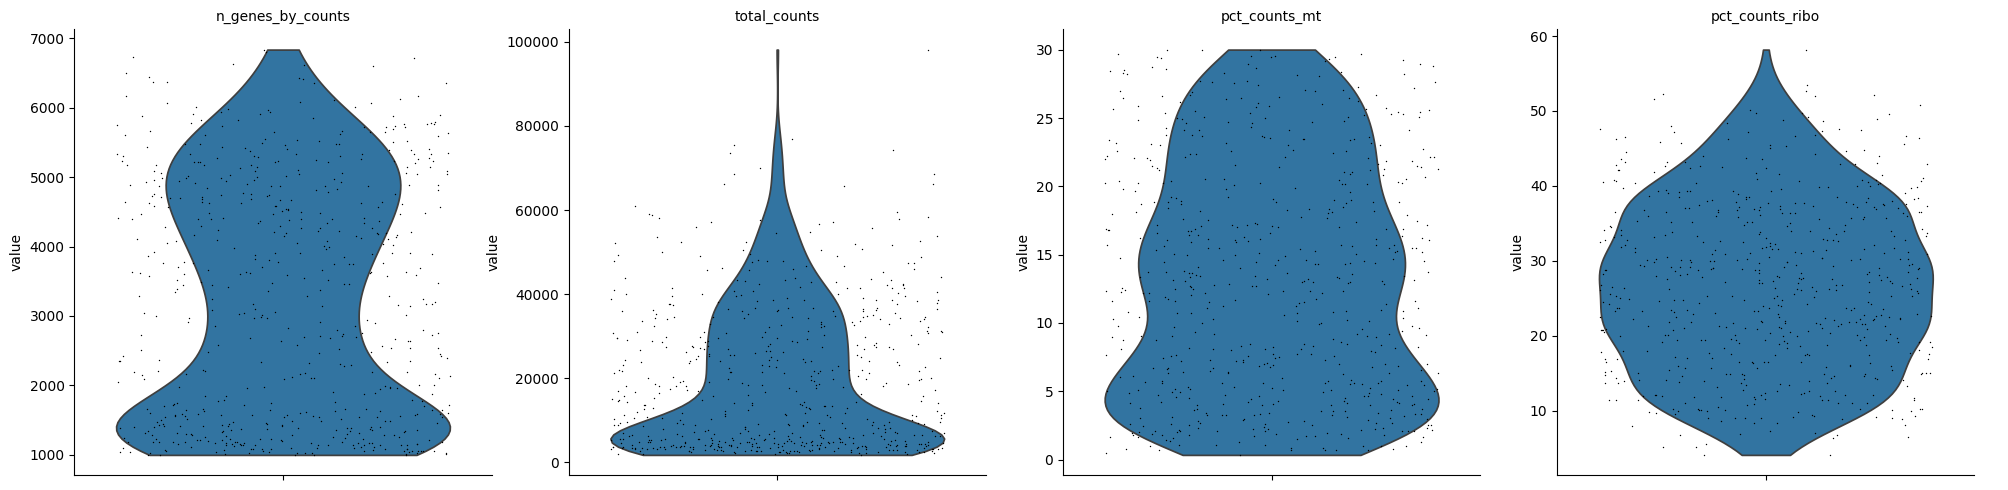

patient_14


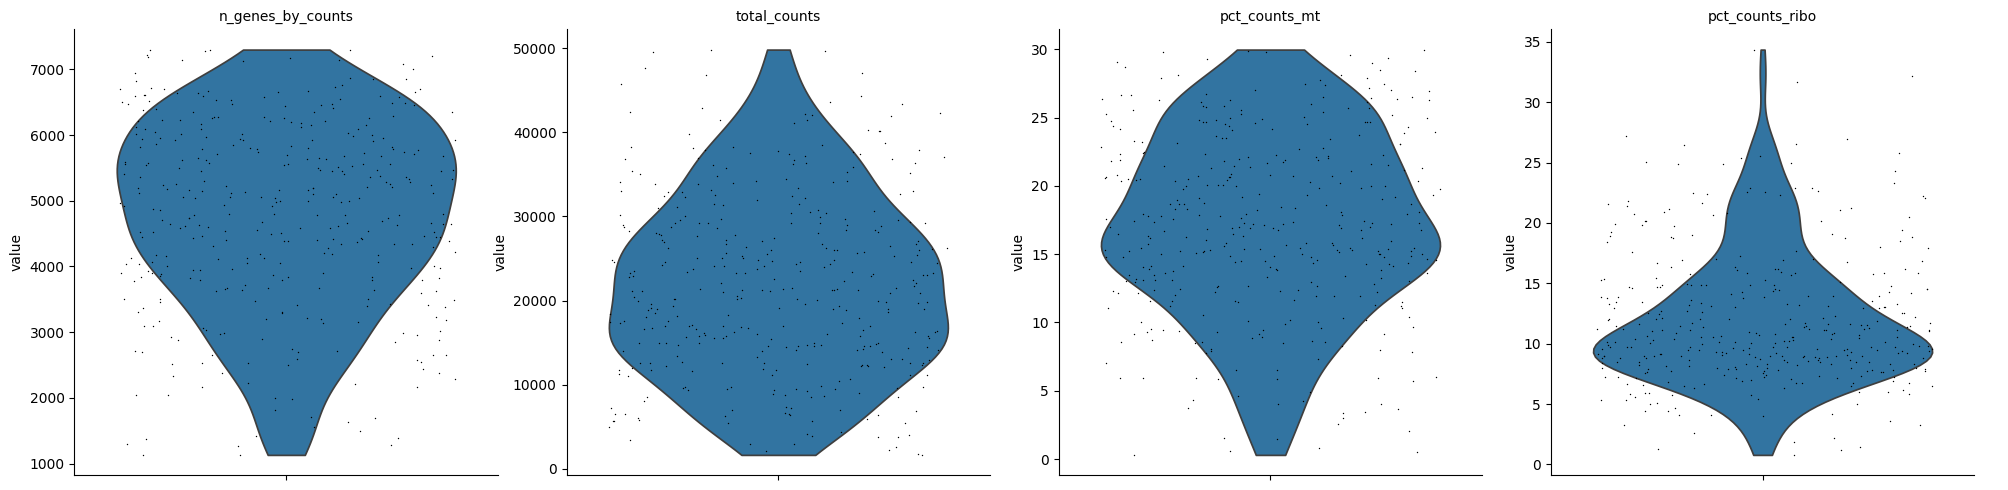

patient_36


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


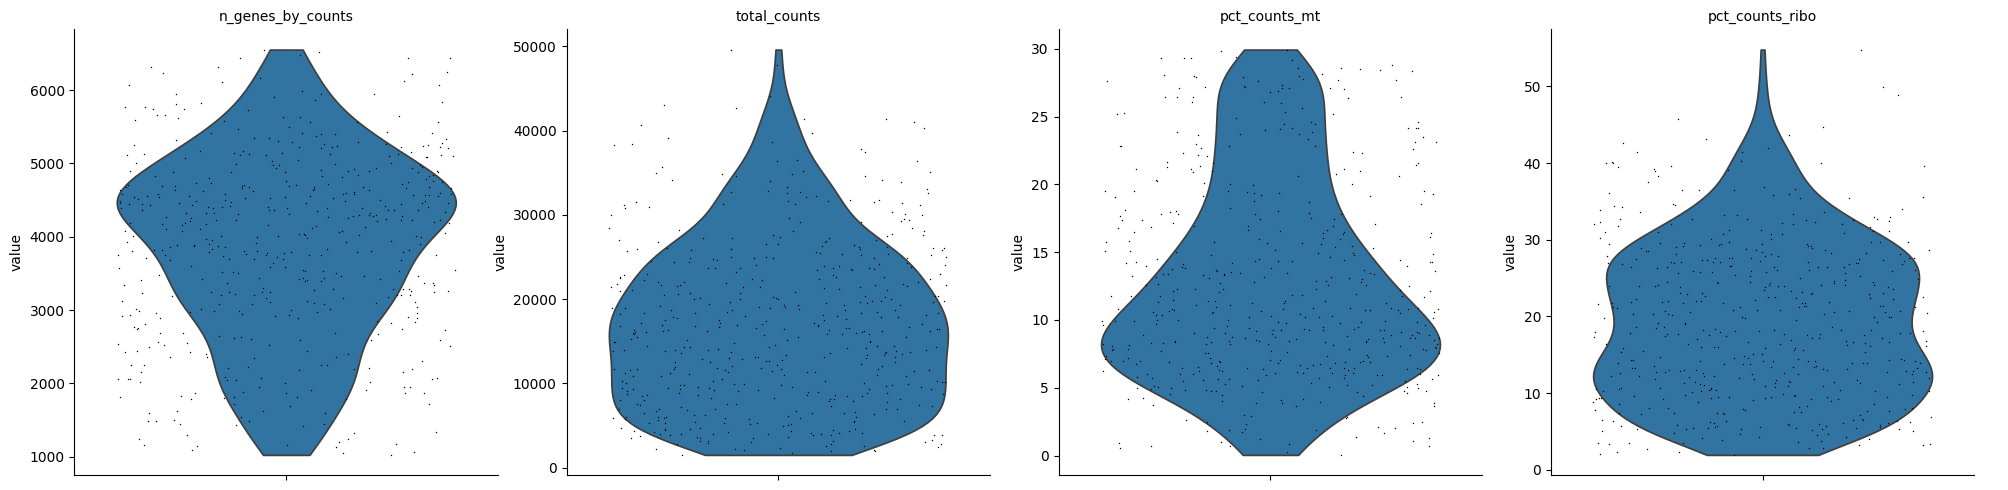

patient_22


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


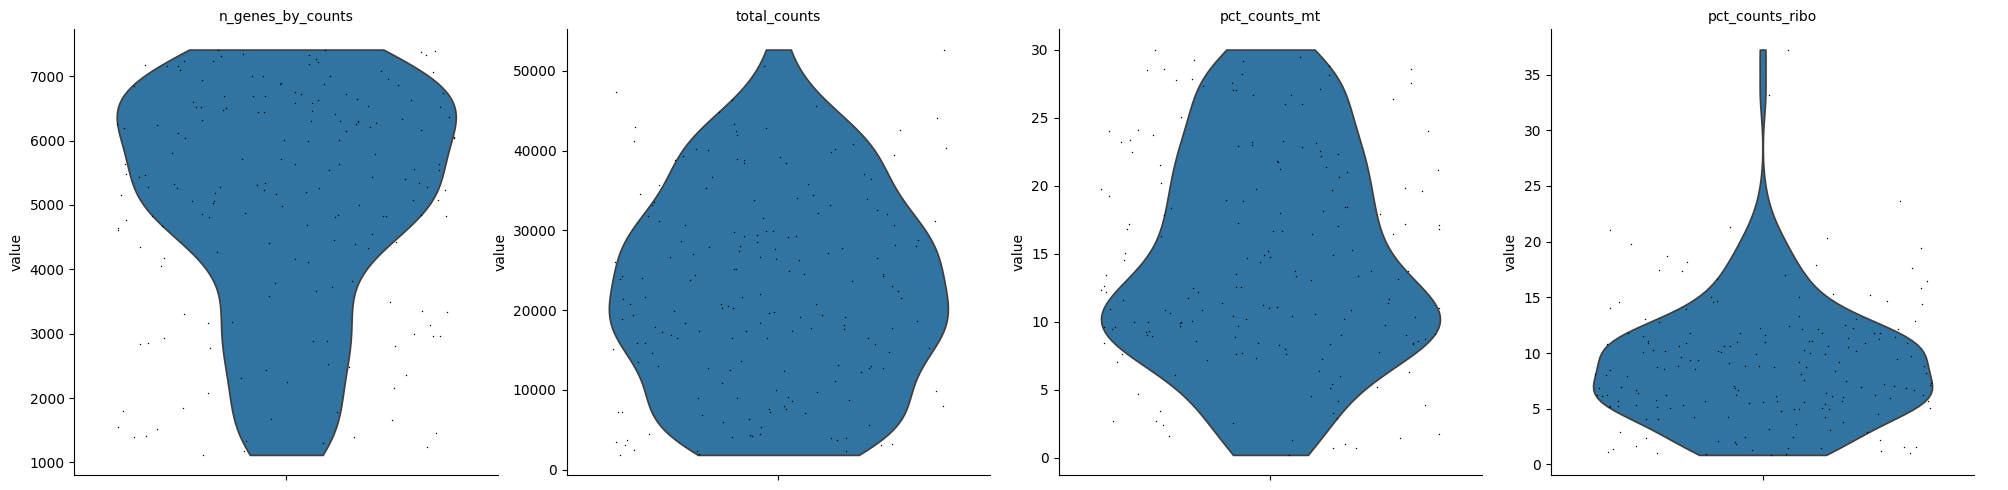

patient_23


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


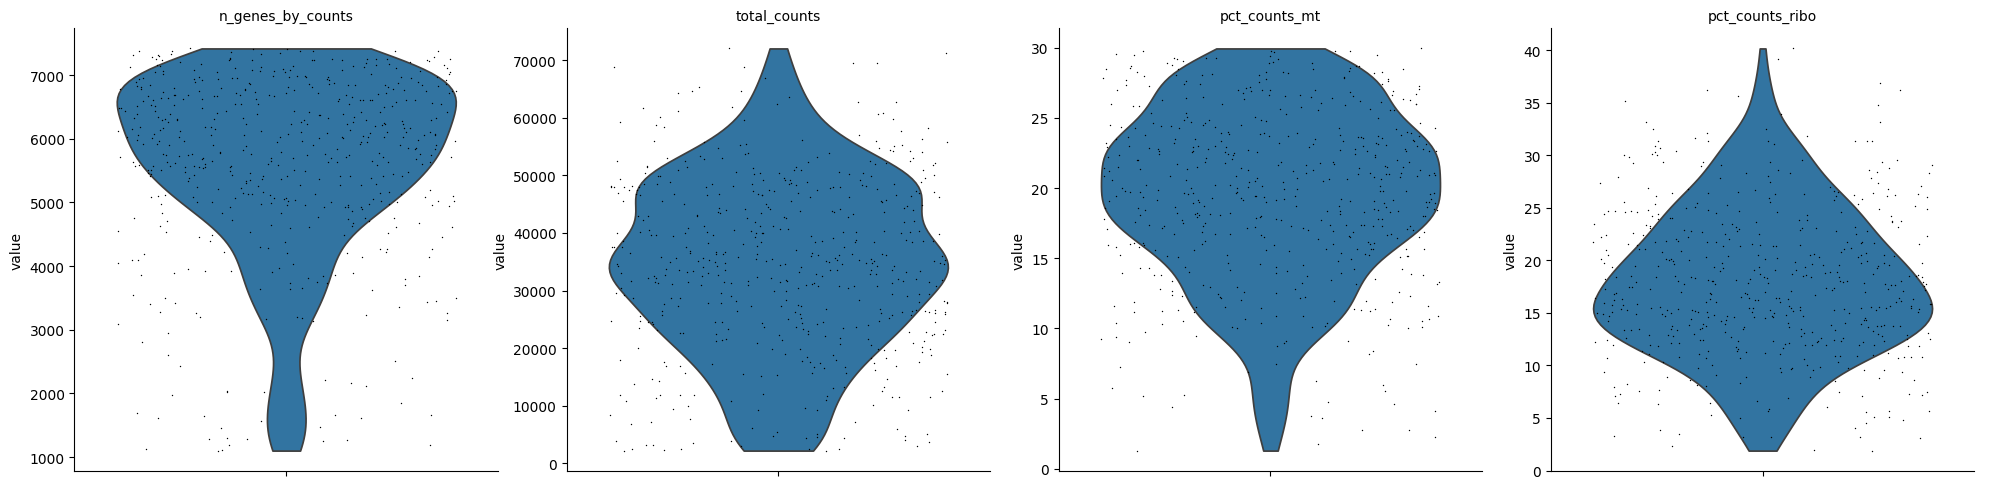

patient_37


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


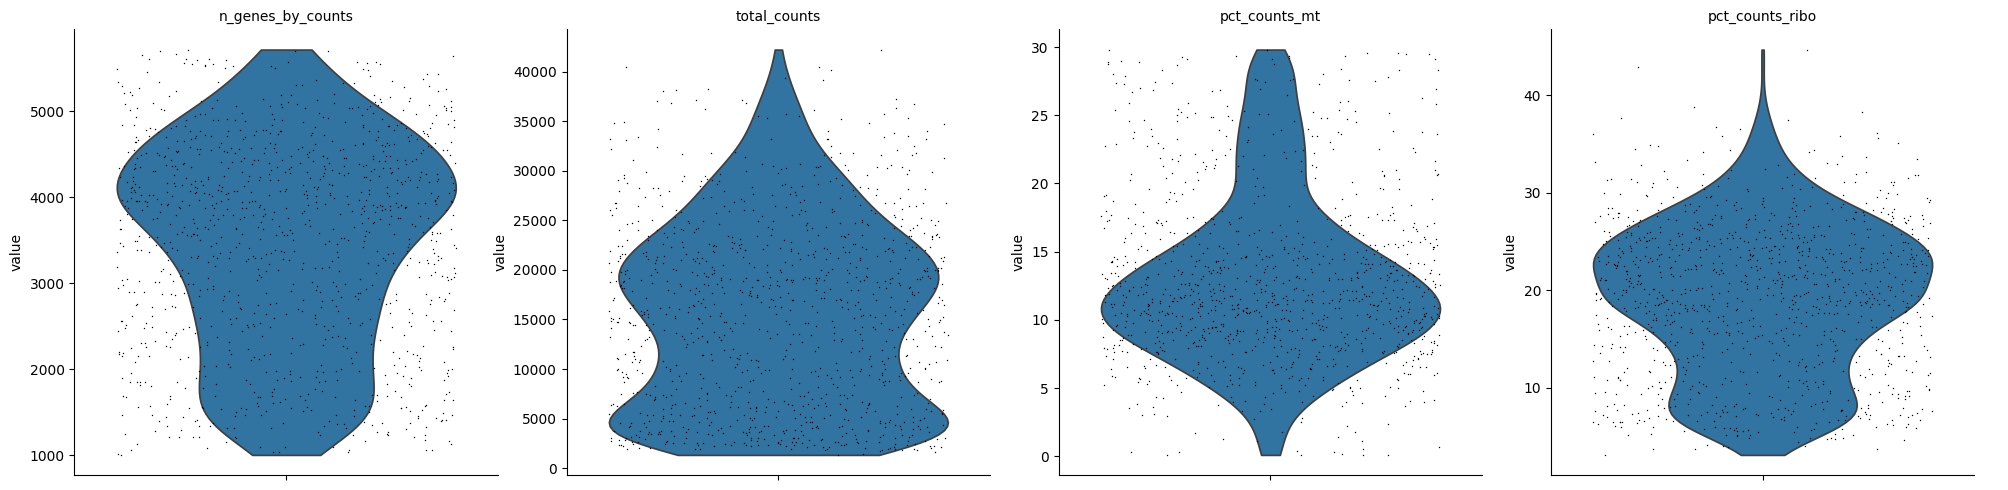

patient_21


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


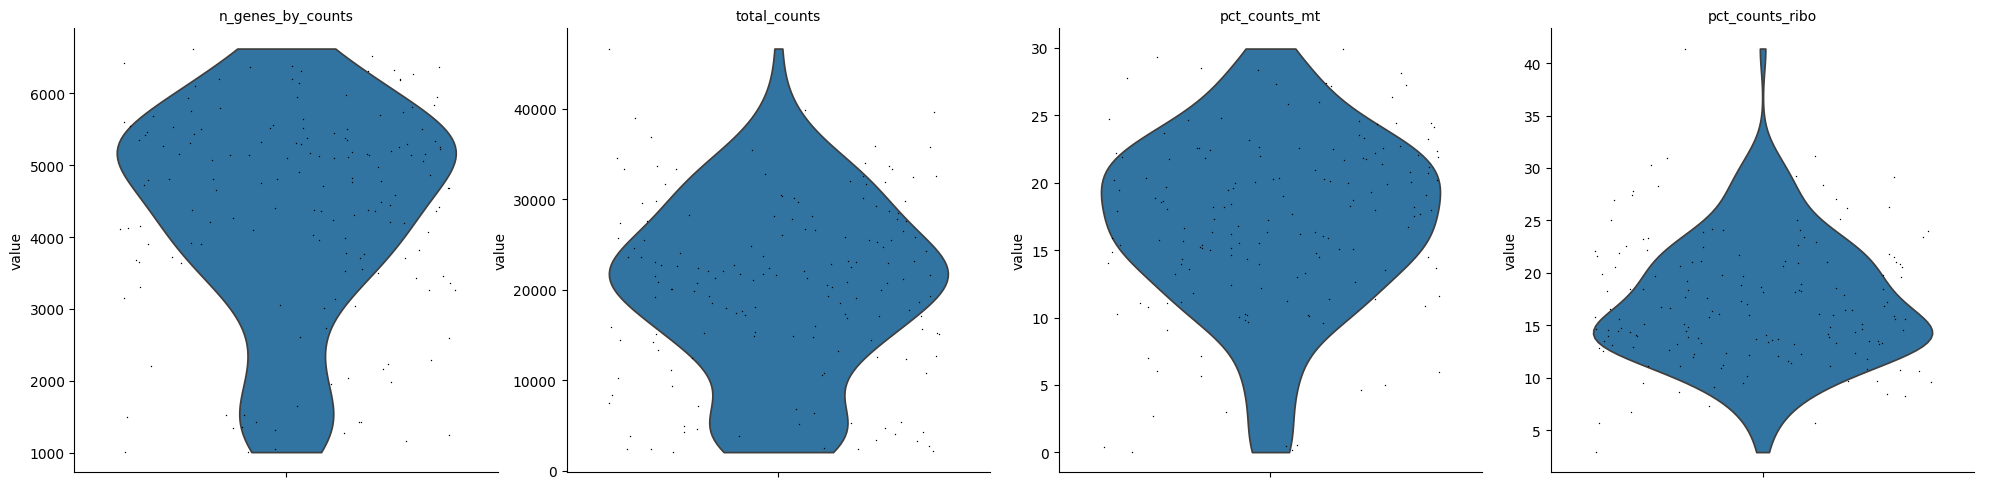

patient_38


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


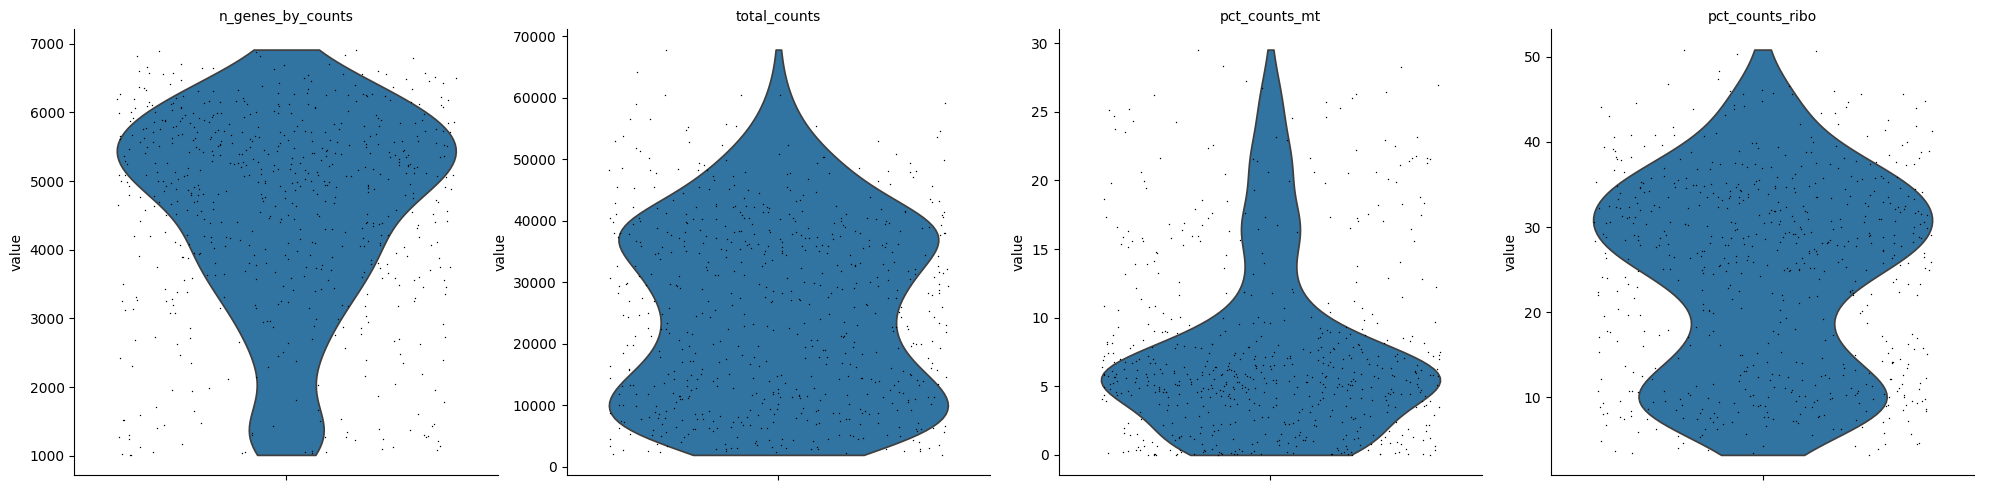

patient_17


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


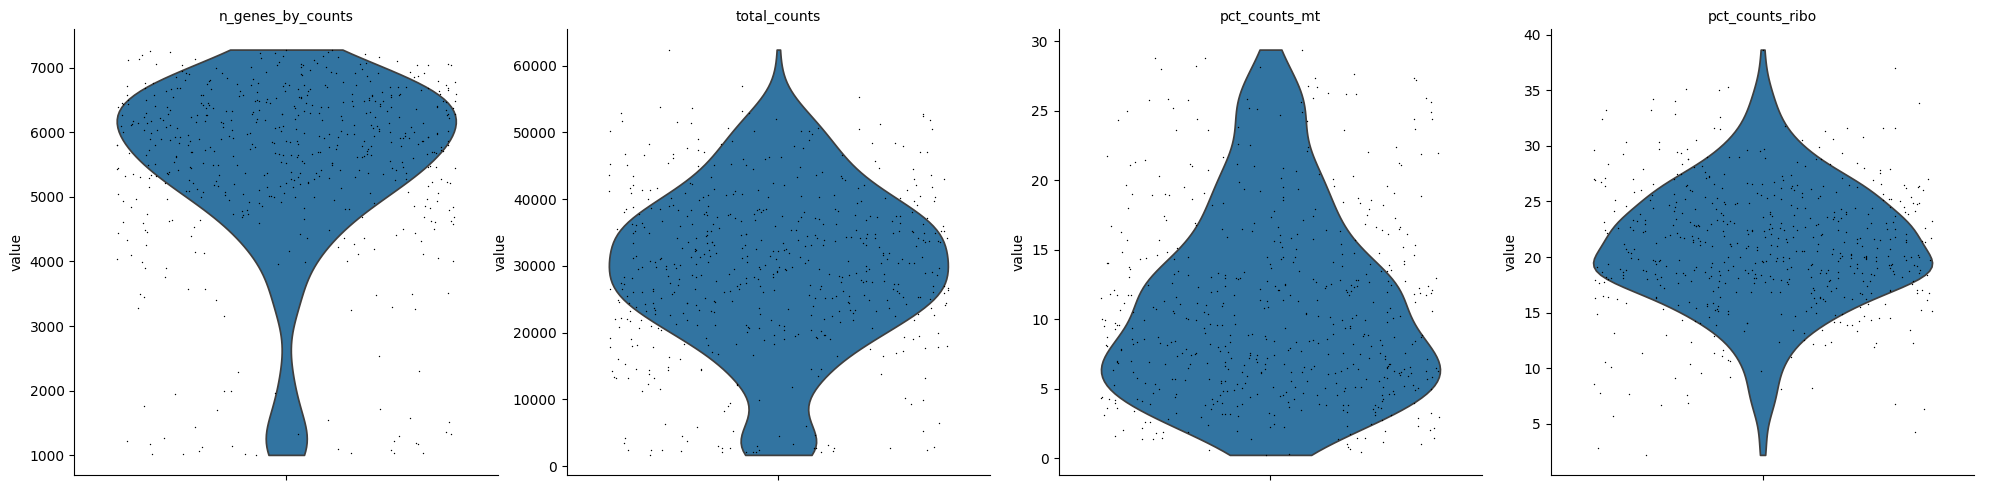

patient_16


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


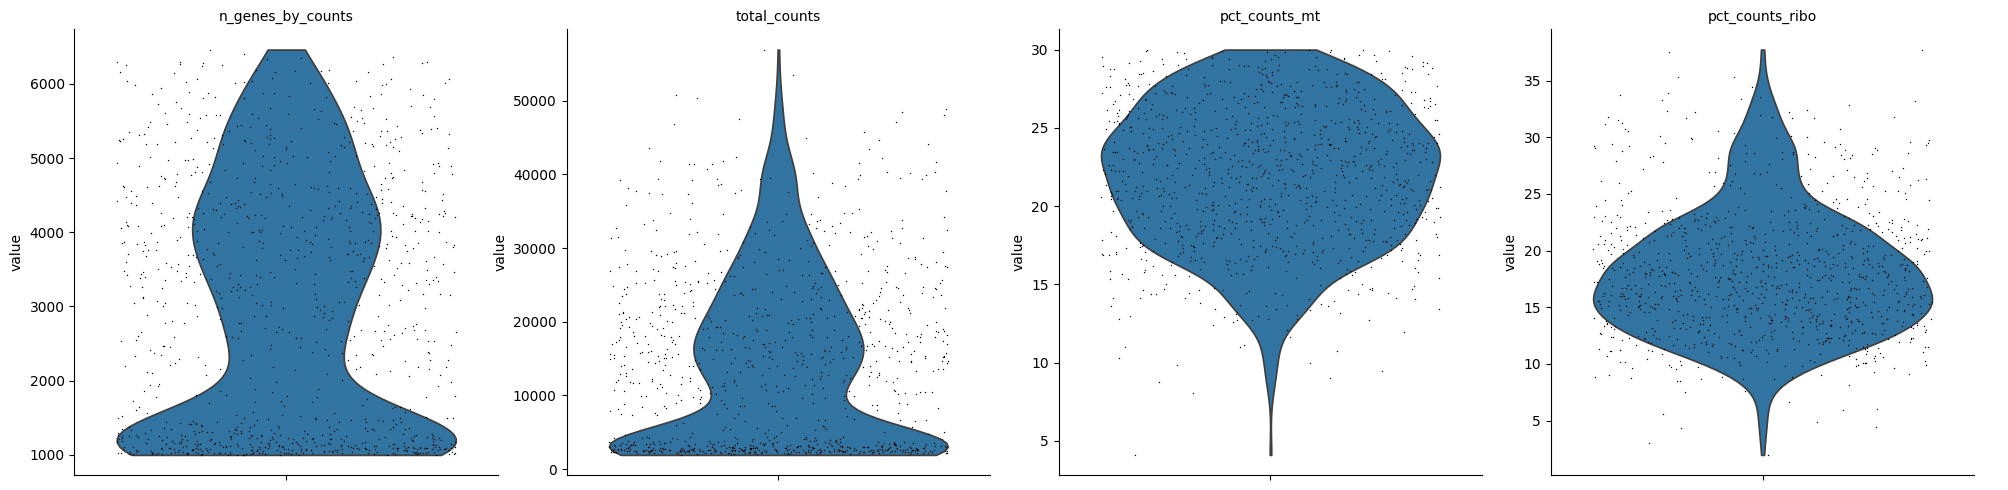

patient_14


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


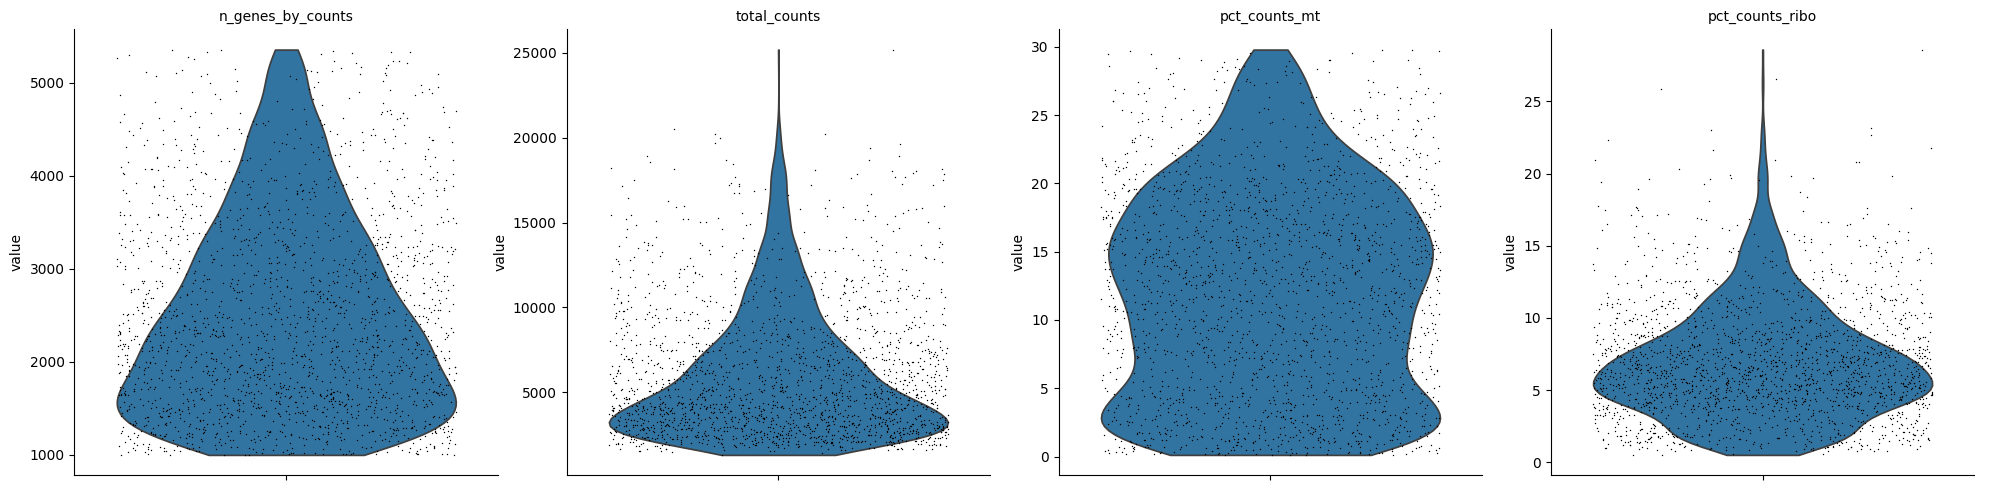

patient_29


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


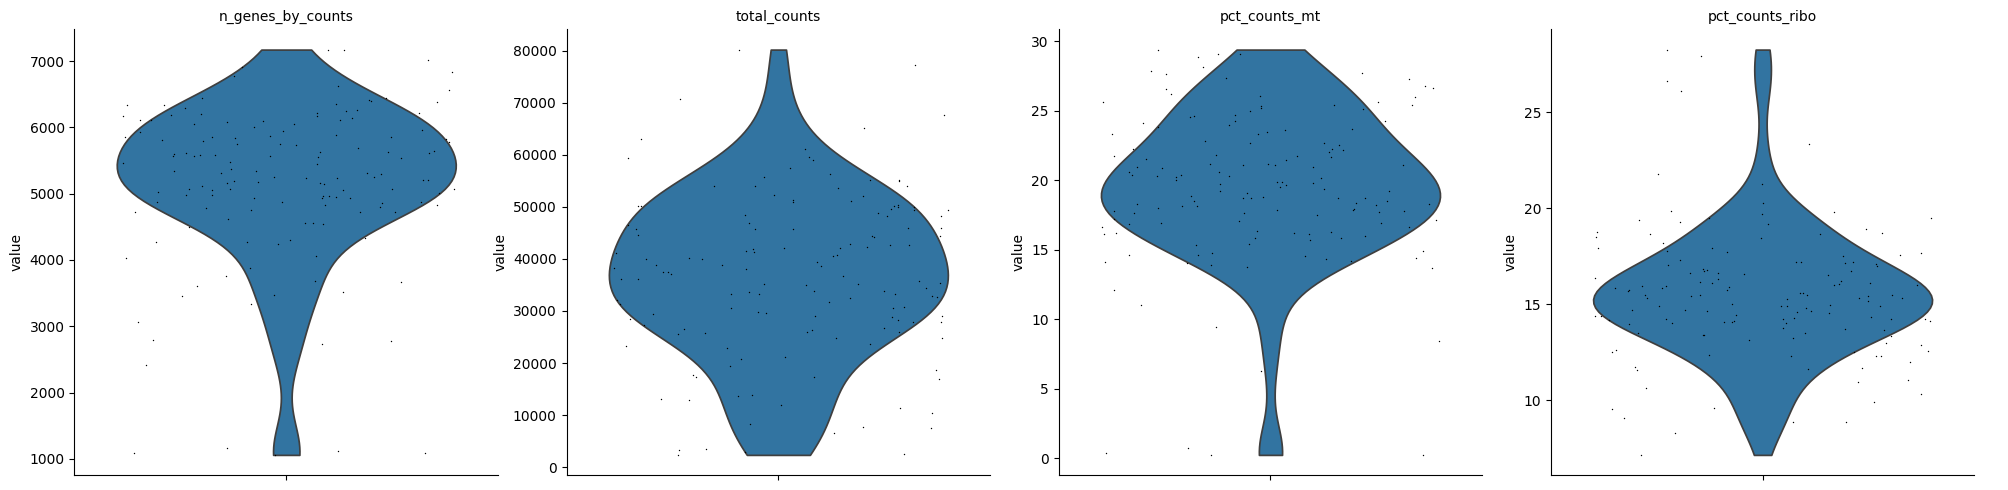

patient_15


/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


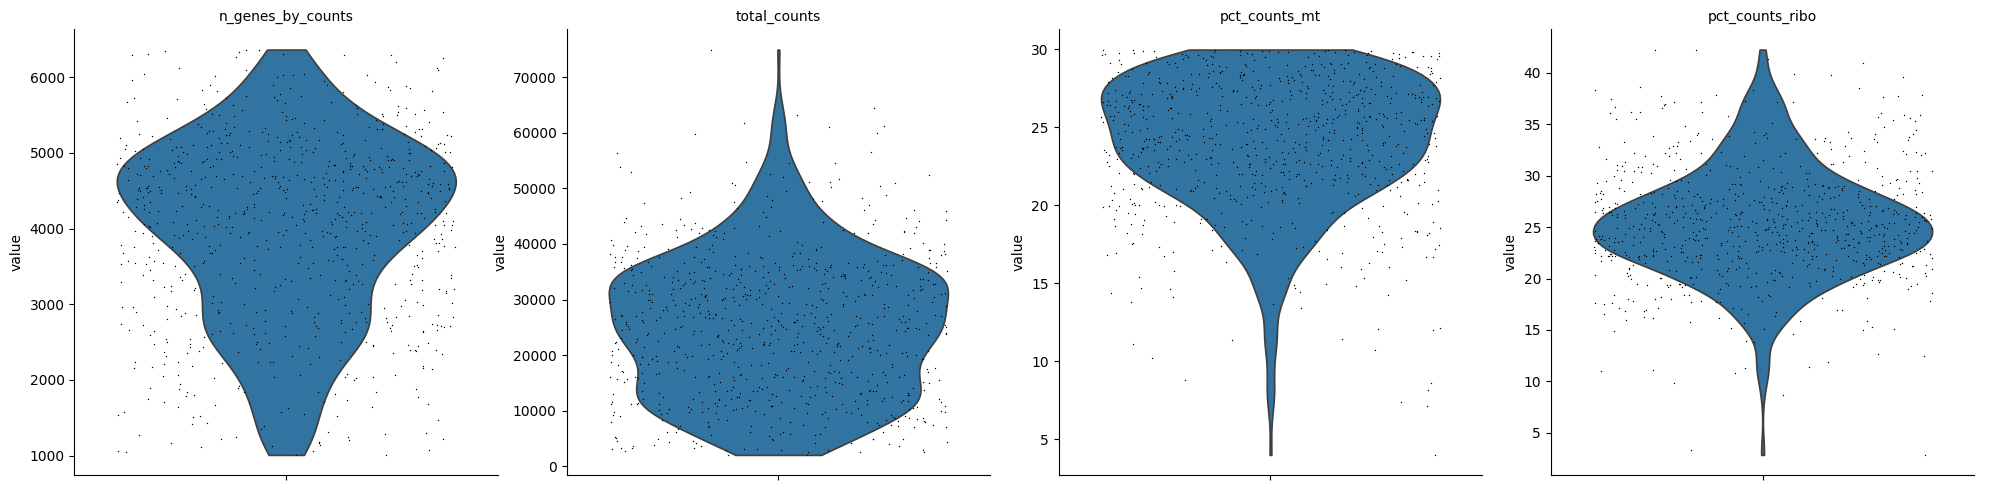

In [26]:
for i in range(len(out)):
    print(out[i].obs.Sample.iloc[0])
    sc.pl.violin(out[i], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [28]:
sc.pp.filter_genes(adata, min_cells=10)

/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [29]:
adata

AnnData object with n_obs × n_vars = 8652 × 10677
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [30]:
adata.X

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 3., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], shape=(8652, 10677), dtype=float32)

In [32]:
#pour gèrer les sparse matrices
from scipy.sparse import csr_matrix

In [33]:
adata.X = csr_matrix(adata.X)

In [34]:
adata.write_h5ad('processed_data/adata2.h5ad')

In [36]:
adata.obs.groupby('Sample').size().sort_values(ascending=False)

/var/folders/jm/8jwl2tjx3l51jrd10w815qv80000gn/T/ipykernel_49922/1338750279.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').size().sort_values(ascending=False)


Sample
patient_14    2401
patient_37    1097
patient_16    1029
patient_15     794
patient_38     644
patient_25     600
patient_17     561
patient_23     530
patient_36     503
patient_22     185
patient_21     164
patient_29     144
dtype: int64

In [81]:
adata.layers['counts'] = adata.X.copy()

In [82]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [83]:
adata

AnnData object with n_obs × n_vars = 8652 × 10677
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

# Modèle scVI

In [84]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset = True, layer = 'counts', 
                            flavor = "seurat_v3", batch_key="Sample")

/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [85]:
adata

AnnData object with n_obs × n_vars = 8652 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [86]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [87]:
model = scvi.model.SCVI(adata)

In [89]:
model.train()

/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 400/400: 100%|██████████| 400/400 [20:48<00:00,  2.94s/it, v_num=1, train_loss_step=4.46e+3, train_loss_epoch=4.5e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [20:48<00:00,  3.12s/it, v_num=1, train_loss_step=4.46e+3, train_loss_epoch=4.5e+3]


In [91]:
model.save("scvi_model/2")

In [55]:
import numpy as np

np.random.seed(2025)

In [92]:
import random

random.seed(2025)

In [93]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [94]:
adata.obsm['X_scVI'].shape

(8652, 10)

In [95]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [96]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

Epoch 149/400:  37%|███▋      | 148/400 [38:03<1:04:48, 15.43s/it, v_num=1, train_loss_step=5.01e+3, train_loss_epoch=4.56e+3]


In [97]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5, n_iterations = 10)

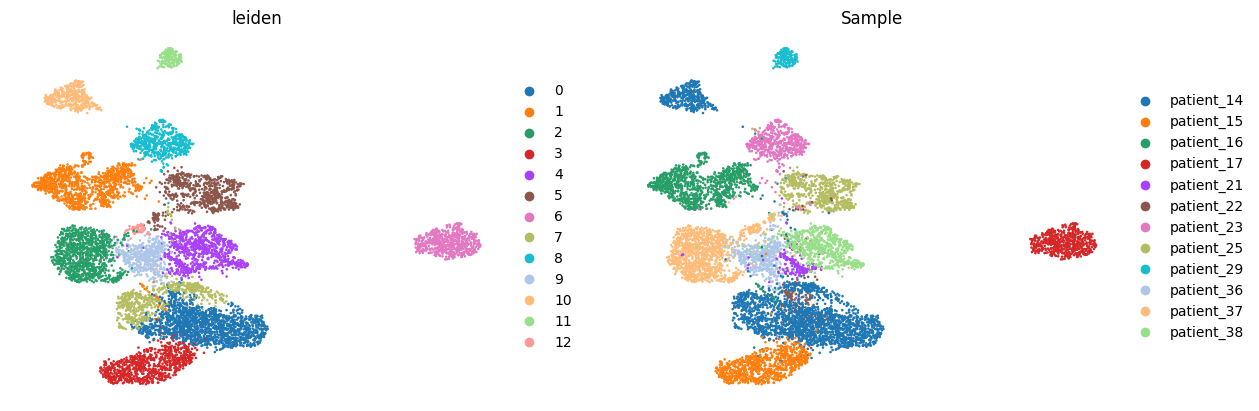

In [65]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

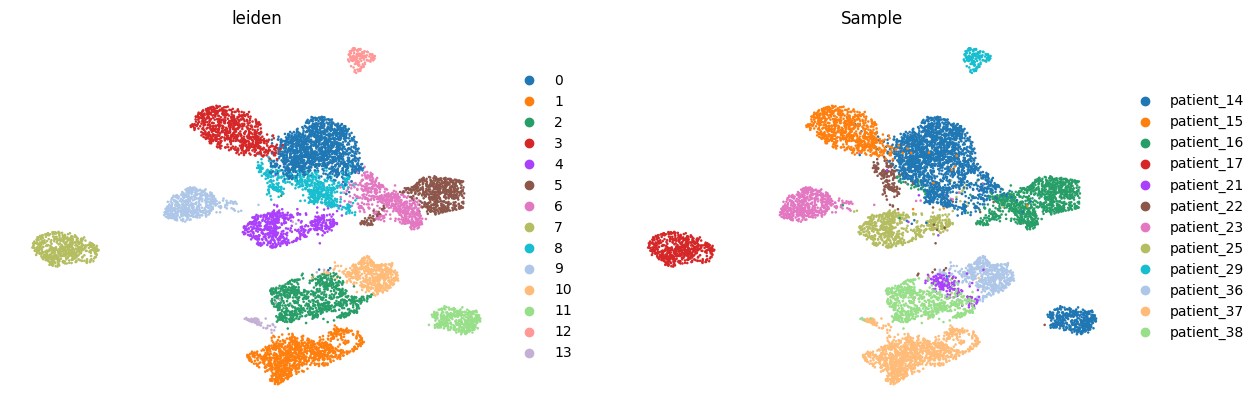

In [98]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [99]:
adata.write_h5ad('processed_data/integrated3.h5ad')

## Labeliser les cellules

In [102]:
sc.tl.leiden(adata, resolution = 1)

In [103]:
sc.tl.rank_genes_groups(adata, 'leiden')

/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/luandechery/Documents/faculdade/python/stage/.conda/lib/

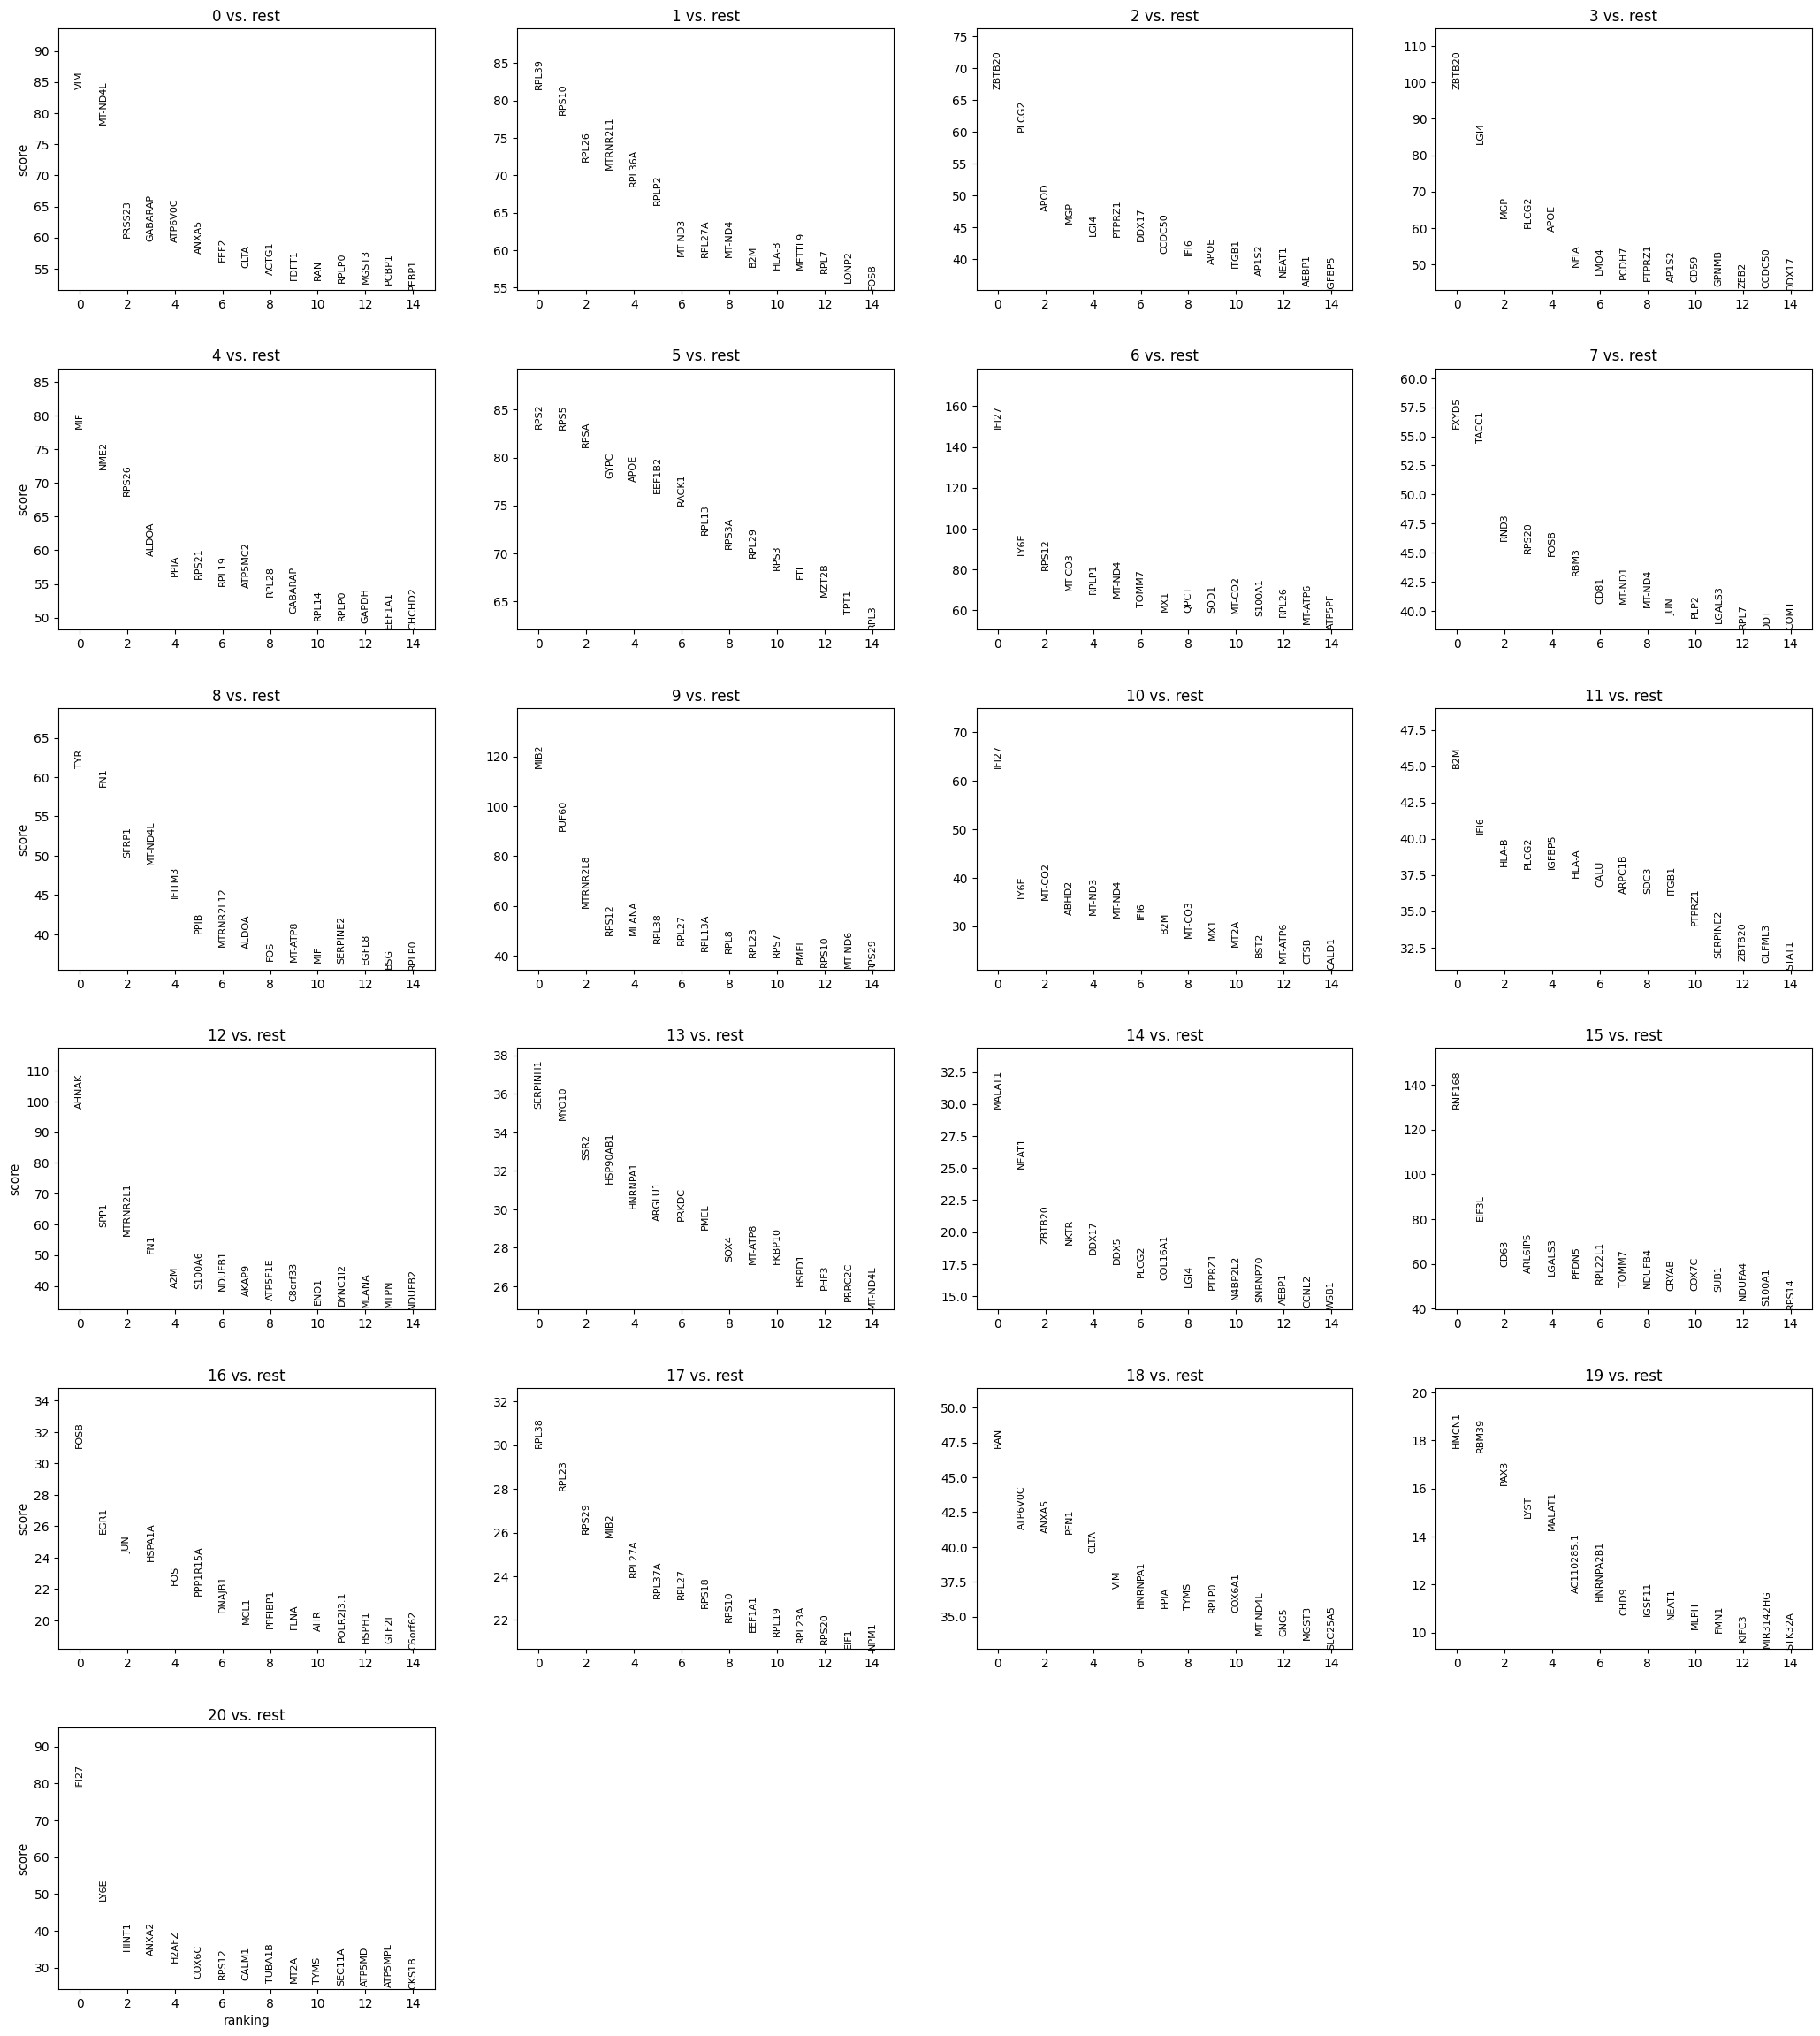

In [107]:
#Les gènes les plus différenciés par cluster
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

In [106]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,VIM,83.922150,2.028916,0.000000,0.000000
1,0,MT-ND4L,78.211288,2.758375,0.000000,0.000000
2,0,PRSS23,59.939419,3.610428,0.000000,0.000000
3,0,GABARAP,59.373905,3.108912,0.000000,0.000000
4,0,ATP6V0C,59.278427,3.853261,0.000000,0.000000
...,...,...,...,...,...,...
215773,20,TMEM11,2.371352,0.597058,0.022186,0.048952
215775,20,WBP1L,2.368449,0.778889,0.022335,0.049241
215777,20,TARDBP,2.365770,0.539830,0.022464,0.049473
215778,20,PIK3R1,2.364993,0.509759,0.022519,0.049585


In [108]:
markers_scvi = model.differential_expression(groupby = 'leiden', mode='change')
markers_scvi

DE...: 100%|██████████| 21/21 [00:45<00:00,  2.18s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
FDFT1,0.9858,0.0142,4.240211,0.001023,0.000231,0.00012,0.25,2.305180,2.265266,0.900684,...,10.293720,2.846193,0.940594,0.701149,10.703526,2.399048,True,0 vs Rest,0,Rest
PTTG1IP,0.9786,0.0214,3.822732,0.001348,0.000420,0.00012,0.25,1.762138,1.805839,0.684411,...,12.896586,5.224494,0.962596,0.816092,14.017521,4.273479,True,0 vs Rest,0,Rest
TUBB4A,0.9746,0.0254,3.647278,0.000628,0.000089,0.00012,0.25,3.360817,3.346874,1.552952,...,6.748063,1.329465,0.842684,0.411985,6.796896,0.885797,True,0 vs Rest,0,Rest
CERS4,0.9738,0.0262,3.615446,0.000299,0.000044,0.00012,0.25,3.125961,3.148088,1.302819,...,2.410339,0.452806,0.807481,0.276637,3.043146,0.397185,True,0 vs Rest,0,Rest
LNP1,0.9730,0.0270,3.584547,0.000142,0.000023,0.00012,0.25,2.856991,2.870944,1.020819,...,1.336634,0.218907,0.564356,0.145422,1.439510,0.193318,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSDMB,0.0788,0.9212,2.458764,0.000005,0.000005,0.00003,0.25,0.643902,0.740389,1.319059,...,0.000000,0.023583,0.000000,0.021724,0.000000,0.026106,False,20 vs Rest,20,Rest
PIM2,0.0672,0.9328,2.630517,0.000009,0.000009,0.00003,0.25,0.120928,0.112626,0.785345,...,0.181818,0.059828,0.159091,0.055646,0.080838,0.049105,False,20 vs Rest,20,Rest
F8,0.0482,0.9518,2.982996,0.000008,0.000008,0.00003,0.25,0.084905,0.029071,0.710945,...,0.181818,0.079344,0.159091,0.074117,0.073033,0.072683,False,20 vs Rest,20,Rest
NUDT18,0.0430,0.9570,3.102603,0.000005,0.000006,0.00003,0.25,0.045205,-0.053476,0.883594,...,0.090909,0.063429,0.090909,0.059363,0.048842,0.055976,False,20 vs Rest,20,Rest


In [109]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
FDFT1,0.9858,0.0142,4.240211,0.001023,0.000231,0.00012,0.25,2.305180,2.265266,0.900684,...,10.293720,2.846193,0.940594,0.701149,10.703526,2.399048,True,0 vs Rest,0,Rest
PTTG1IP,0.9786,0.0214,3.822732,0.001348,0.000420,0.00012,0.25,1.762138,1.805839,0.684411,...,12.896586,5.224494,0.962596,0.816092,14.017521,4.273479,True,0 vs Rest,0,Rest
TUBB4A,0.9746,0.0254,3.647278,0.000628,0.000089,0.00012,0.25,3.360817,3.346874,1.552952,...,6.748063,1.329465,0.842684,0.411985,6.796896,0.885797,True,0 vs Rest,0,Rest
CERS4,0.9738,0.0262,3.615446,0.000299,0.000044,0.00012,0.25,3.125961,3.148088,1.302819,...,2.410339,0.452806,0.807481,0.276637,3.043146,0.397185,True,0 vs Rest,0,Rest
LNP1,0.9730,0.0270,3.584547,0.000142,0.000023,0.00012,0.25,2.856991,2.870944,1.020819,...,1.336634,0.218907,0.564356,0.145422,1.439510,0.193318,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARPIN,0.9172,0.0828,2.404897,0.000072,0.000027,0.00003,0.25,1.675898,1.486432,1.064822,...,1.727273,0.255574,0.636364,0.196213,0.808011,0.247078,True,20 vs Rest,20,Rest
HSP90AA1,0.9170,0.0830,2.402267,0.008948,0.004056,0.00003,0.25,1.281314,1.269385,0.742689,...,168.068176,48.536060,1.000000,0.987918,81.780312,38.597664,True,20 vs Rest,20,Rest
KNL1,0.9168,0.0832,2.399642,0.000149,0.000027,0.00003,0.25,3.092780,3.167960,1.866586,...,2.454545,0.116055,0.772727,0.046468,1.212273,0.097992,True,20 vs Rest,20,Rest
FANCD2,0.9166,0.0834,2.397023,0.000053,0.000014,0.00003,0.25,2.319715,2.397531,1.278482,...,1.227273,0.104786,0.590909,0.067844,0.563259,0.079394,True,20 vs Rest,20,Rest


source pour trouver les gènes marqueurs :
https://panglaodb.se/markers.html?cell_type=%27Merkel%20cells%27

### genes marqueurs de Mélanocytes / Mélanome 

"Description: Melanocytes are melanin-producing neural crest-derived cells located in the bottom layer (the stratum basale) of the skin's epidermis. Melanocytes have been found in the meninges of the brain, eyes, heart and other organs."

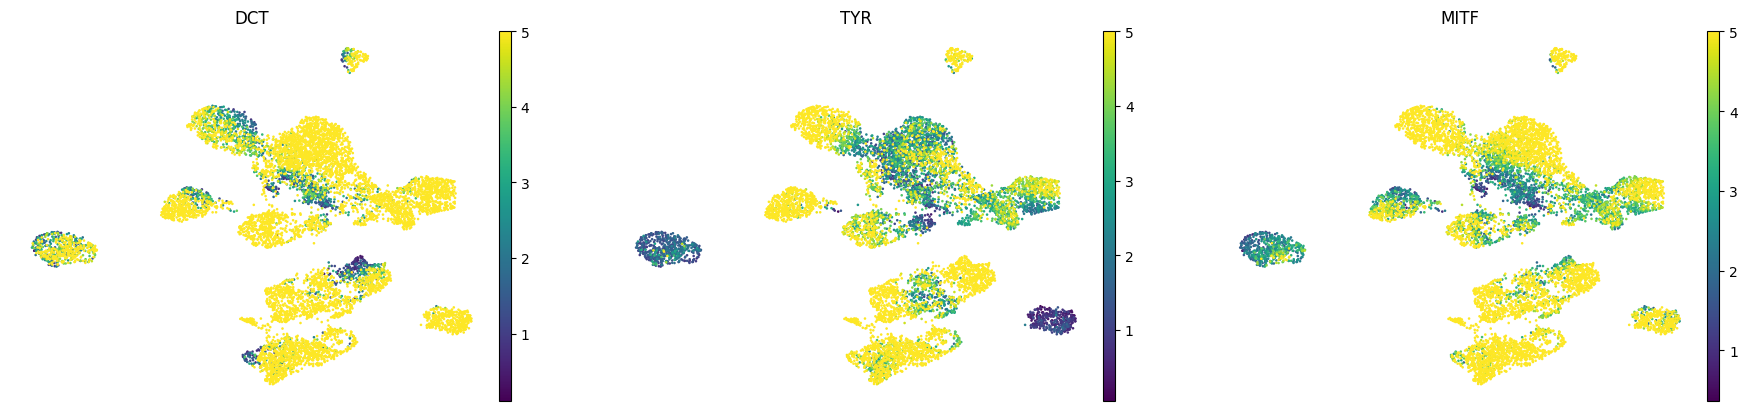

In [110]:
sc.pl.umap(adata, color = ['DCT', 'TYR', 'MITF'], frameon = False, layer = 'scvi_normalized', vmax = 5)

### Merkel cells

"Description: Merkel cells are oval-shaped mechanoreceptors essential for light touch sensation and found in the skin of vertebrates. They are abundant in highly sensitive skin like that of the fingertips in humans."

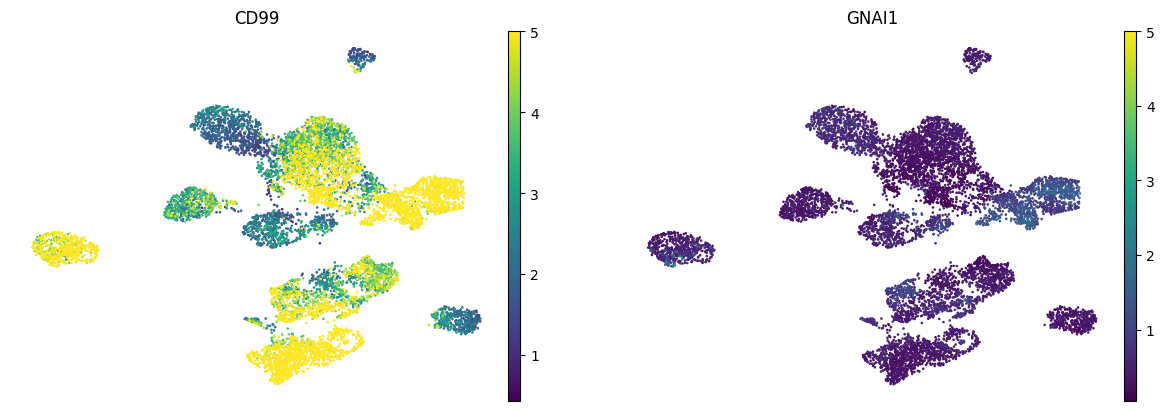

In [122]:
sc.pl.umap(adata, color = ['CD99', 'GNAI1'], frameon = False, layer = 'scvi_normalized', vmax = 5)